In [1]:
from importlib import reload
from itertools import chain

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

from evaluation import evaluator

In [2]:
path = "../datasets/"
data = arff.loadarff('%sSeattle_Crime_Data_06-23-2019-4.arff' % path)
df = pd.DataFrame(data[0])
#take onyl first 10000

for column in df.columns:
    # decode bytes to string for each column
    df[column] = df[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

df = df.drop('Report_Number', axis=1)
original_dtypes = df.dtypes
df.replace(['NONE', '?', '', 'None', b'', np.NaN, 'UNKNOWN'], pd.NA, inplace=True)
df

,Occurred_Time,Reported_Time,Crime_Subcategory,Primary_Offense_Description,Precinct,Sector,Beat,Neighborhood
0,900.0,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK
1,1.0,2359.0,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,<NA>,<NA>,<NA>,<NA>
2,1600.0,1430.0,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
3,2029.0,2030.0,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,BRIGHTON/DUNLAP
4,2000.0,435.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,ROXHILL/WESTWOOD/ARBOR HEIGHTS
...,...,...,...,...,...,...,...,...
523585,1713.0,1713.0,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTH,O,O3,MID BEACON HILL
523586,730.0,1721.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,C,C2,MONTLAKE/PORTAGE BAY
523587,1724.0,1724.0,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,SOUTH,S,S2,RAINIER BEACH
523588,1750.0,1904.0,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,L,L2,NORTHGATE


In [3]:
for column in df.columns:
    if df.columns.dtype == object:
        print(column + "=" * 40)
        value_counts = df[column].value_counts()
        print(value_counts)


Occurred_Time========================================
Occurred_Time
2200.0    13858
1800.0    13804
0.0       13420
2000.0    12836
1200.0    12598
          ...  
649.0        40
607.0        39
546.0        39
627.0        37
551.0        36
Name: count, Length: 1440, dtype: int64
Reported_Time========================================
Reported_Time
1300.0    824
1600.0    809
1530.0    799
1400.0    790
1230.0    787
         ... 
501.0      89
333.0      89
542.0      85
417.0      85
349.0      85
Name: count, Length: 1440, dtype: int64
Crime_Subcategory========================================
Crime_Subcategory
CAR PROWL                              148263
THEFT-ALL OTHER                         54419
THEFT-SHOPLIFT                          48638
BURGLARY-RESIDENTIAL                    46843
MOTOR VEHICLE THEFT                     43529
BURGLARY-COMMERCIAL                     23531
THEFT-BUILDING                          21438
TRESPASS                                17722
NARCOTIC  

# Preprocessing

In [4]:
# split dataframe to features and target
y = df['Primary_Offense_Description']  #target 
#df.drop('Crime_Subcategory', axis=1, inplace=True)
X = df.drop('Primary_Offense_Description', axis=1)  # Features


# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Occurred_Time,Reported_Time,Crime_Subcategory,Precinct,Sector,Beat,Neighborhood
6916,2108.0,2108.0,NARCOTIC,NORTH,N,N3,NORTHGATE
70131,2100.0,623.0,BURGLARY-RESIDENTIAL,NORTH,N,N2,BITTERLAKE
64578,2130.0,1033.0,MOTOR VEHICLE THEFT,WEST,D,D3,SLU/CASCADE
30304,2150.0,2335.0,NARCOTIC,SOUTH,S,S1,NEW HOLLY
218777,1858.0,1858.0,THEFT-ALL OTHER,SOUTH,S,S2,BRIGHTON/DUNLAP
...,...,...,...,...,...,...,...
259178,711.0,711.0,AGGRAVATED ASSAULT-DV,NORTH,J,J3,GREENWOOD
365838,500.0,822.0,CAR PROWL,NORTH,J,J3,ROOSEVELT/RAVENNA
131932,1135.0,1151.0,THEFT-SHOPLIFT,WEST,M,M3,DOWNTOWN COMMERCIAL
146867,2100.0,105.0,BURGLARY-RESIDENTIAL,NORTH,U,U1,ROOSEVELT/RAVENNA


In [5]:
print("null values in train data: " + str(X_train.isnull().sum().sum()))
print("null values in test data: " + str(X_test.isnull().sum().sum()))
print(X_train.dtypes)

null values in train data: 10869
null values in test data: 2759
Occurred_Time        object
Reported_Time        object
Crime_Subcategory    object
Precinct             object
Sector               object
Beat                 object
Neighborhood         object
dtype: object


In [6]:
imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

imputer.fit(X_train)

# original_dtypes = X_train.dtypes
del original_dtypes['Primary_Offense_Description']
#del original_dtypes['Crime_Subcategory']
X_train_np = imputer.transform(X_train)
X_train = pd.DataFrame(X_train_np, index=X_train.index, columns=X_train.columns)
X_train = X_train.astype(original_dtypes)

X_test_np = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_np, index=X_test.index, columns=X_test.columns)
X_test = X_test.astype(original_dtypes)

In [7]:
print("null values in train data: " + str(X_train.isnull().sum().sum()))
print("null values in test data: " + str(X_test.isnull().sum().sum()))

null values in train data: 0
null values in test data: 0


In [8]:
X_train

,Occurred_Time,Reported_Time,Crime_Subcategory,Precinct,Sector,Beat,Neighborhood
6916,2108.0,2108.0,NARCOTIC,NORTH,N,N3,NORTHGATE
70131,2100.0,623.0,BURGLARY-RESIDENTIAL,NORTH,N,N2,BITTERLAKE
64578,2130.0,1033.0,MOTOR VEHICLE THEFT,WEST,D,D3,SLU/CASCADE
30304,2150.0,2335.0,NARCOTIC,SOUTH,S,S1,NEW HOLLY
218777,1858.0,1858.0,THEFT-ALL OTHER,SOUTH,S,S2,BRIGHTON/DUNLAP
...,...,...,...,...,...,...,...
259178,711.0,711.0,AGGRAVATED ASSAULT-DV,NORTH,J,J3,GREENWOOD
365838,500.0,822.0,CAR PROWL,NORTH,J,J3,ROOSEVELT/RAVENNA
131932,1135.0,1151.0,THEFT-SHOPLIFT,WEST,M,M3,DOWNTOWN COMMERCIAL
146867,2100.0,105.0,BURGLARY-RESIDENTIAL,NORTH,U,U1,ROOSEVELT/RAVENNA


In [9]:
# find all numerical columns in X_train
numerical_columns = X_train.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_columns = numerical_columns.tolist()
numerical_columns

['Occurred_Time', 'Reported_Time']

In [10]:
feature_mappings = {}

ordinal_columns = [col for col in X_train.columns if col in feature_mappings.keys()]
ordinal_categories = [feature_mappings[col] for col in ordinal_columns]
ordinal_columns

[]

In [11]:
categorical_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numerical_columns]

one_hot_encoding_limit = 5
one_hot_columns = [col for col in categorical_columns if X_train[col].nunique() <= one_hot_encoding_limit]

label_columns = [col for col in categorical_columns if col not in one_hot_columns]

print("one hot columns: ", one_hot_columns)
print("label columns: ", label_columns)

one hot columns:  ['Precinct']
label columns:  ['Crime_Subcategory', 'Sector', 'Beat', 'Neighborhood']


In [12]:
all = numerical_columns + ordinal_columns + one_hot_columns + label_columns
all.sort()
all

['Beat',
 'Crime_Subcategory',
 'Neighborhood',
 'Occurred_Time',
 'Precinct',
 'Reported_Time',
 'Sector']

In [13]:
preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_columns),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), label_columns)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

In [14]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', MinMaxScaler())
])

pipeline_standard = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', StandardScaler())
])
X_train_std = pipeline_standard.fit_transform(X_train)
X_test_std = pipeline_standard.transform(X_test)

# Preprocess training data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [15]:
# Encode target variable
label_encoder = LabelEncoder()

#label = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
#y_train = y_train.map(label)
#y_test = y_test.map(label)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Evaluation


## Neural Network

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 500, 'verbose': True}
Iteration 1, loss = 2.78717992
Iteration 2, loss = 1.95360071
Iteration 3, loss = 1.61179946
Iteration 4, loss = 1.40372302
Iteration 5, loss = 1.26475762
Iteration 6, loss = 1.16285838
Iteration 7, loss = 1.08318879
Iteration 8, loss = 1.01958106
Iteration 9, loss = 0.96835459
Iteration 10, loss = 0.92551280
Iteration 11, loss = 0.88916519
Iteration 12, loss = 0.85792181
Iteration 13, loss = 0.83190731
Iteration 14, loss = 0.80976510
Iteration 15, loss = 0.79063847
Iteration 16, loss = 0.77397819
Iteration 17, loss = 0.75983948
Iteration 18, loss = 0.74730158
Iteration 19, loss = 0.73622585
Iteration 20, loss = 0.72695126
Iteration 21, loss = 0.71814104
Iteration 22, loss = 0.71057032
Iteration 23, loss = 0.70403417
Iteration 24, loss = 0.69782361
Iteration 25, loss = 0.69230190
Iteration 26, loss = 0.68716358
Iteration 27, los

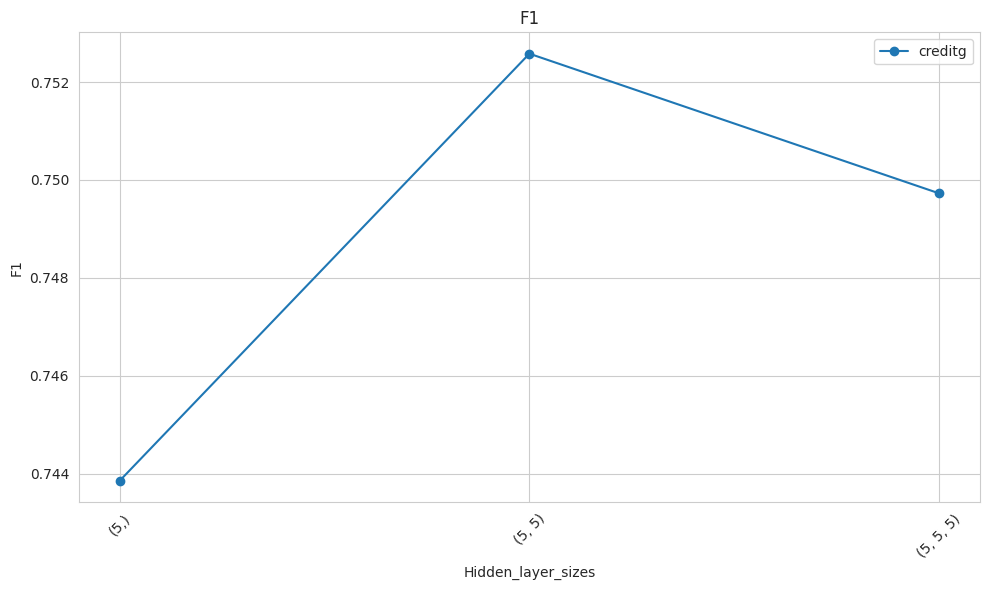

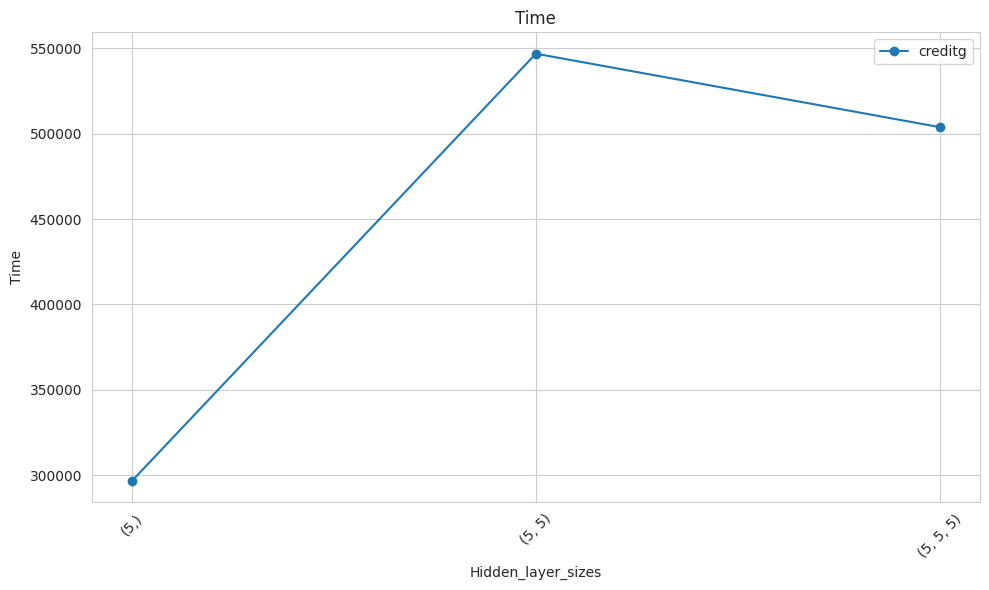

In [20]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 500,
    'verbose': True,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(5, ), (5, 5), (5, 5, 5),]}
nn_hidden_layer_deepness = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=1)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer_deepness}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 500, 'verbose': True, 'tol': 0.01}
Iteration 1, loss = 3.60146361
Iteration 2, loss = 2.95565732
Iteration 3, loss = 2.48338313
Iteration 4, loss = 2.26845405
Iteration 5, loss = 2.18960925
Iteration 6, loss = 2.13668723
Iteration 7, loss = 2.09864385
Iteration 8, loss = 2.06963642
Iteration 9, loss = 2.04634086
Iteration 10, loss = 2.02678260
Iteration 11, loss = 2.01026876
Iteration 12, loss = 1.99599644
Iteration 13, loss = 1.98339607
Iteration 14, loss = 1.97216398
Iteration 15, loss = 1.96205377
Iteration 16, loss = 1.95284613
Iteration 17, loss = 1.94436269
Iteration 18, loss = 1.93641173
Iteration 19, loss = 1.92912715
Iteration 20, loss = 1.92228316
Iteration 21, loss = 1.91592661
Iteration 22, loss = 1.90992344
Iteration 23, loss = 1.90425295
Iteration 24, loss = 1.89887365
Iteration 25, loss = 1.89381147
Iteration 26, loss = 1.88895247
Trai

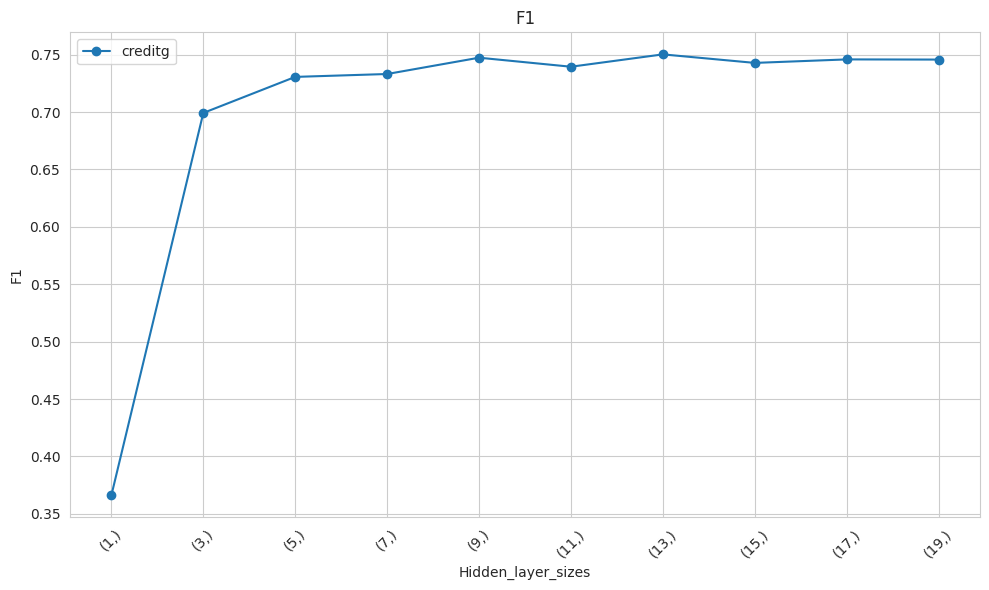

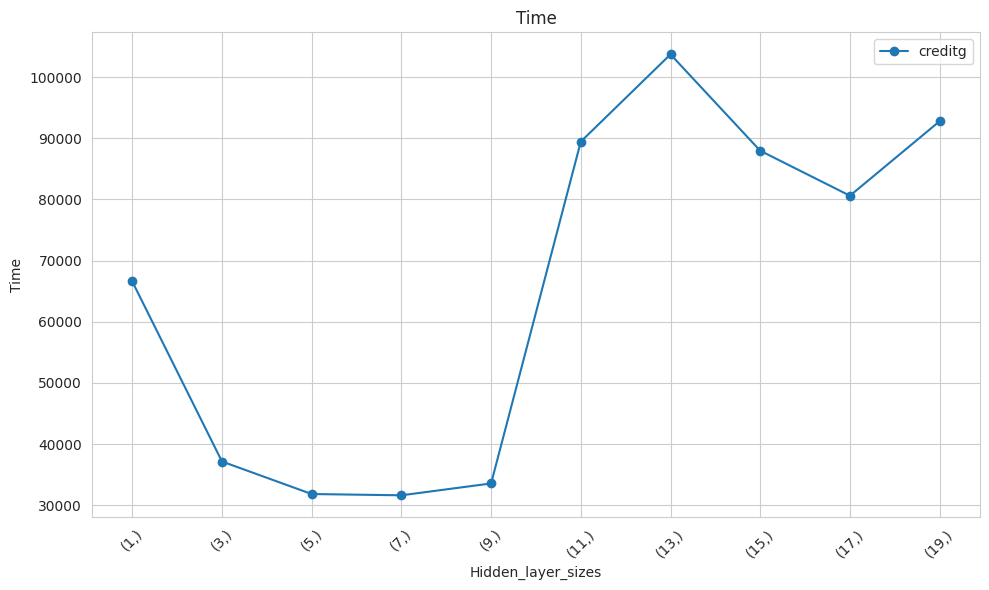

In [26]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 500,
    'verbose': True,
    'tol': 1e-2
}
hyperparameters_iterator = {'hidden_layer_sizes': [(i,) for i in chain(range(1, 20, 2),)]}
nn_hidden_layer = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=1)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (7,), 'max_iter': 500, 'verbose': False, 'tol': 0.05}
done with  learning_rate_init   1e-05  results:  {'accuracy': 0.24983288450887145, 'recall': 0.24983288450887145, 'precision': 0.06241647018202309, 'f1': 0.09987970544806074, 'time': 30176.398277282715, 'learning_rate_init': 1e-05}
done with  learning_rate_init   2.2758459260747865e-05  results:  {'accuracy': 0.34666437479707407, 'recall': 0.34666437479707407, 'precision': 0.14761455832519974, 'f1': 0.19815554941157795, 'time': 19751.239776611328, 'learning_rate_init': 2.2758459260747865e-05}
done with  learning_rate_init   5.1794746792312125e-05  results:  {'accuracy': 0.44388739280734923, 'recall': 0.44388739280734923, 'precision': 0.2303876679339499, 'f1': 0.29861504975927927, 'time': 23960.617542266846, 'learning_rate_init': 5.1794746792312125e-05}
done with  learning_rate_init   0.0

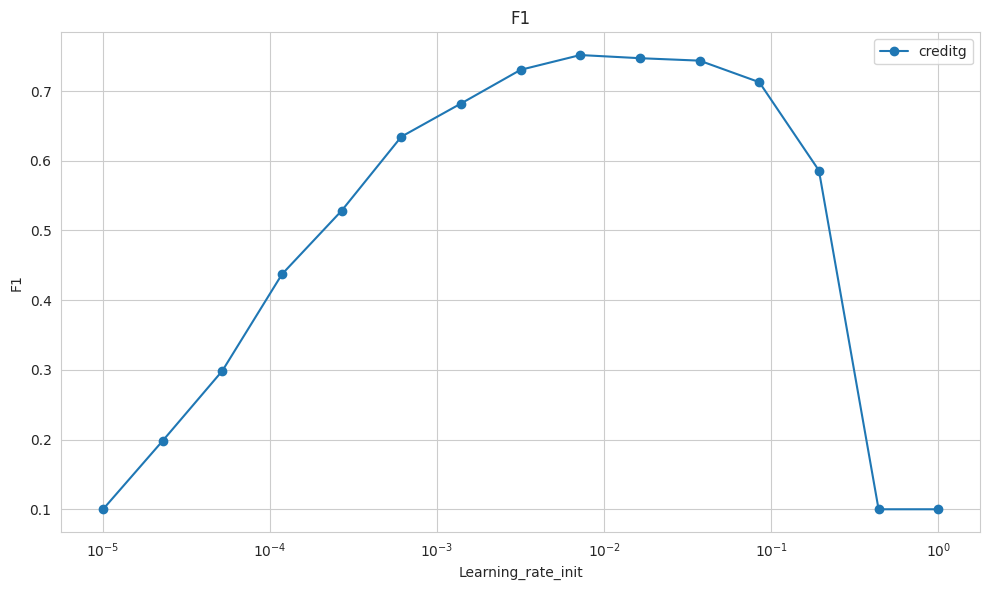

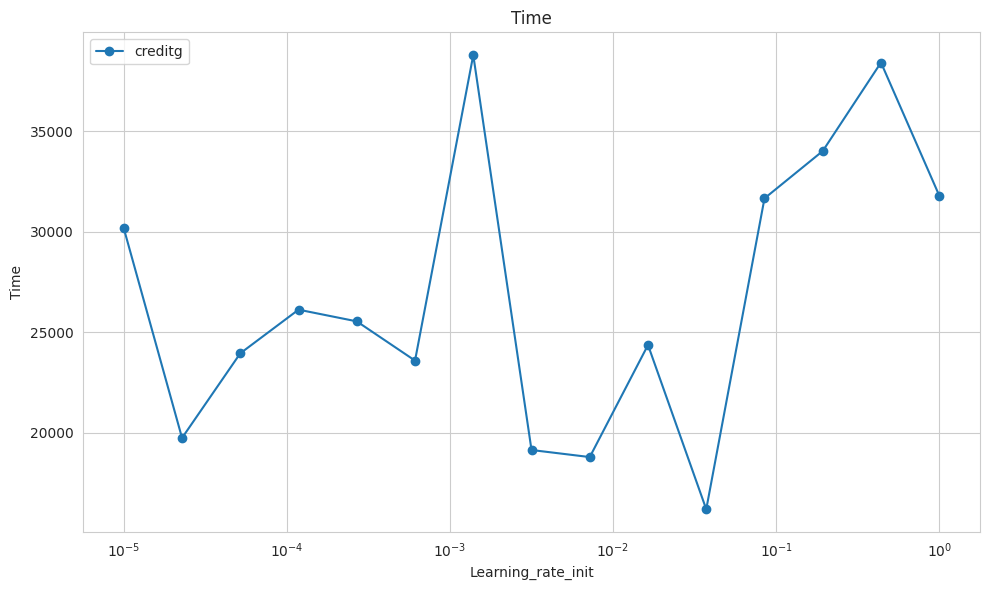

In [16]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    'max_iter': 500,
    'verbose': False,
    'tol': 5e-2
}
hyperparameters_iterator = {'learning_rate_init': np.logspace(-5, 0, num=15)}
nn_learning_rate = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=1)
evaluator.draw_diagram2_list({"creditg": nn_learning_rate}, x_axis='learning_rate_init', y_axis=['f1', 'time'], logaritmic=True)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (5,), 'max_iter': 500, 'verbose': False, 'tol': 0.05}
done with  activation   identity  results:  {'accuracy': 0.7829790484921408, 'recall': 0.7829790484921408, 'precision': 0.7100510049241778, 'f1': 0.7266970545266919, 'time': 14539.355993270874, 'activation': 'identity'}
done with  activation   logistic  results:  {'accuracy': 0.7932160660058443, 'recall': 0.7932160660058443, 'precision': 0.6761705086868904, 'f1': 0.7227080989402314, 'time': 13880.494832992554, 'activation': 'logistic'}
done with  activation   tanh  results:  {'accuracy': 0.7907905040203212, 'recall': 0.7907905040203212, 'precision': 0.6903948325791216, 'f1': 0.7231515339246929, 'time': 13978.725671768188, 'activation': 'tanh'}
done with  activation   relu  results:  {'accuracy': 0.7918409442502722, 'recall': 0.7918409442502722, 'precision': 0.6802297609745291, 'f1':

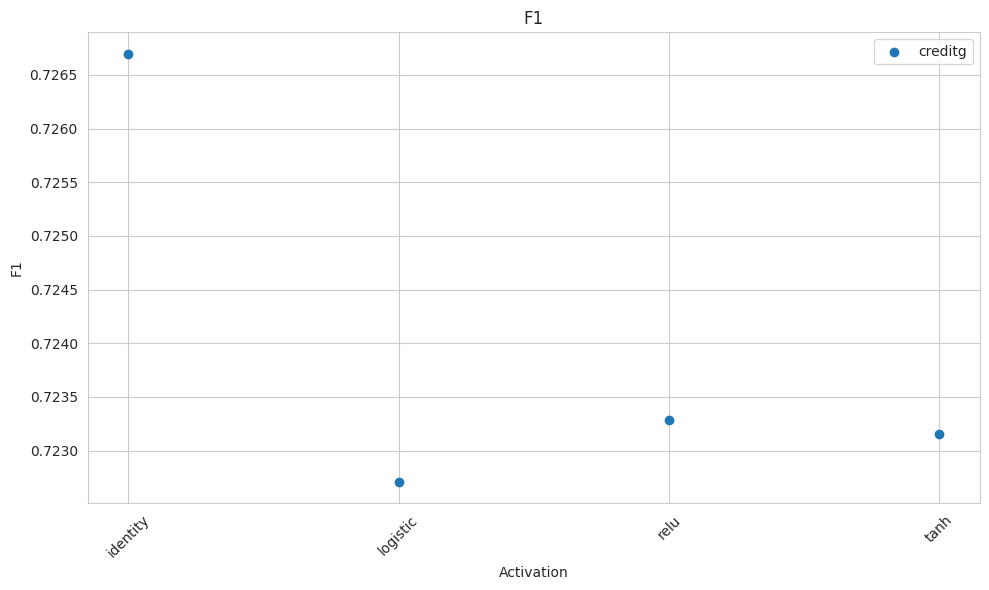

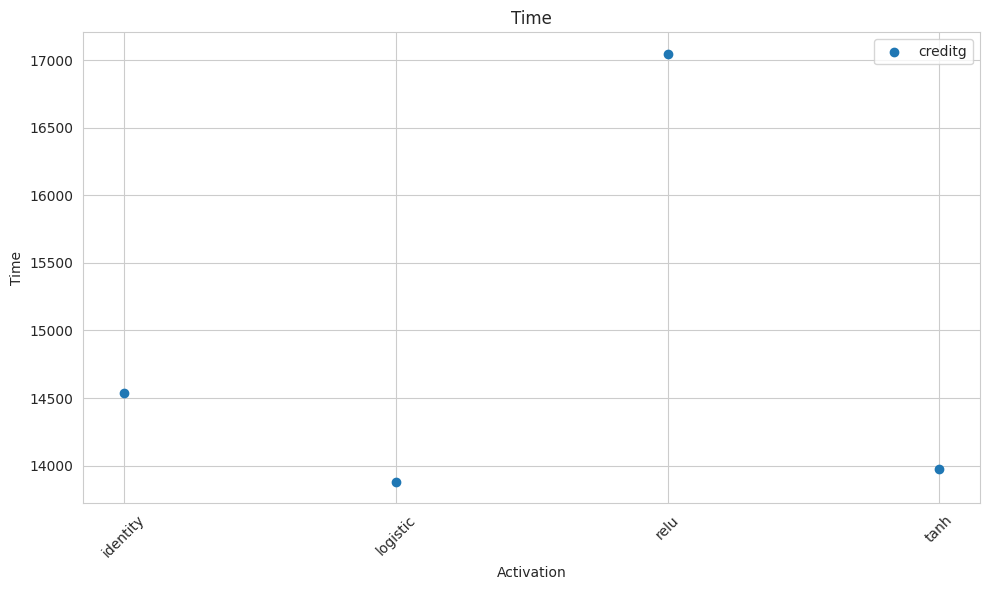

In [30]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    #'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-1,
    'hidden_layer_sizes': (5,),
    #'random_state': 7895,
    'max_iter': 500,
    'verbose': False,
    'tol': 5e-2
}
hyperparameters_iterator = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
act_function1 = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator, number_of_tests=1)
evaluator.draw_diagram2_list({"creditg": act_function1,},
                             x_axis='activation', y_axis=['f1', 'time'],
                             logaritmic=False, line=False)

## Random Forest

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'criterion': 'gini', 'verbose': False}
done with  n_estimators   1  results:  {'accuracy': 0.7247082640997727, 'recall': 0.7247082640997727, 'precision': 0.7269063976208805, 'f1': 0.7257114782061738, 'time': 679.8970699310303, 'n_estimators': 1}
done with  n_estimators   5  results:  {'accuracy': 0.7595160335376917, 'recall': 0.7595160335376917, 'precision': 0.7341689075132022, 'f1': 0.7453511285881308, 'time': 2993.098258972168, 'n_estimators': 5}
done with  n_estimators   10  results:  {'accuracy': 0.773124009243874, 'recall': 0.773124009243874, 'precision': 0.7423245502603265, 'f1': 0.7555106226876279, 'time': 5888.0064487457275, 'n_estimators': 10}
done with  n_estimators   50  results:  {'accuracy': 0.7792070131209534, 'recall': 0.7792070131209534, 'precision': 0.7444547409957852, 'f1': 0.759144386005493, 'time': 29400.46763420105, 'n_estimators': 50}
done with  n_estimators   100  results:  {'accuracy': 0.780161958

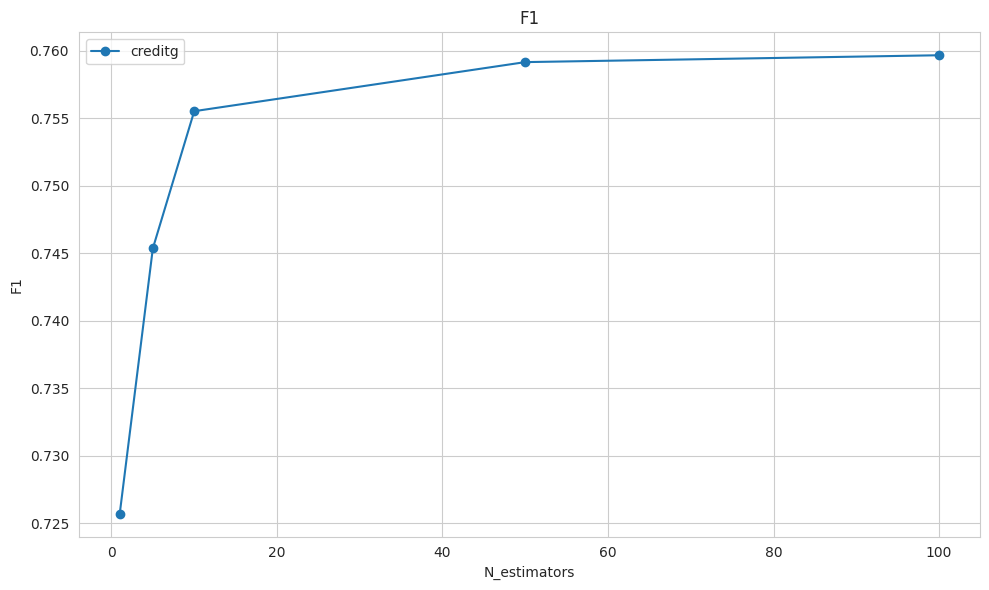

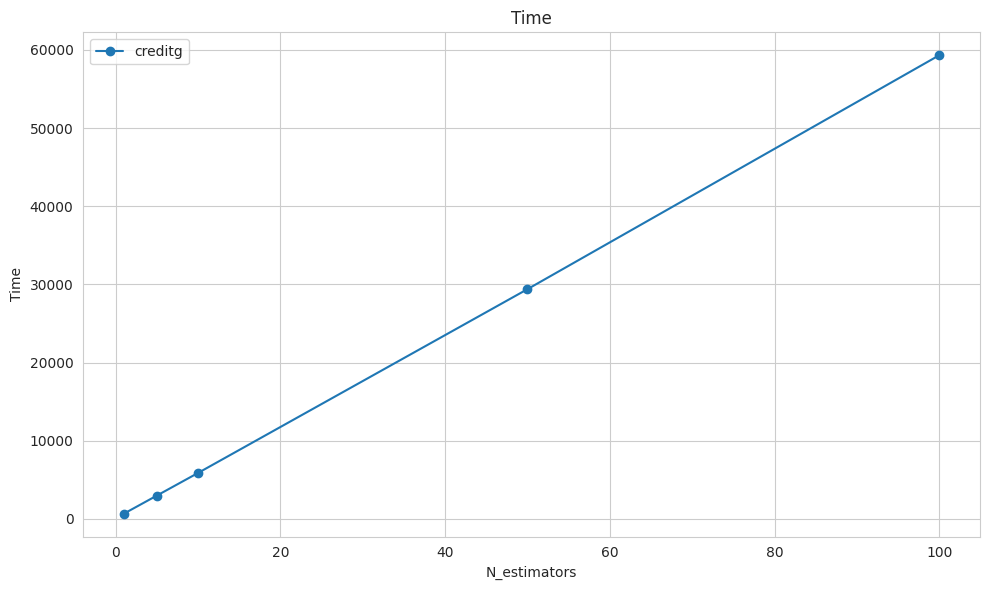

In [16]:
from itertools import chain

hyperparameters = {
    #'n_estimators': 100,
    'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'n_estimators': [1, 5, 10, 50, 100]}
rf_n_estimators = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=1)
evaluator.draw_diagram2_list({"creditg": rf_n_estimators}, x_axis='n_estimators', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'n_estimators': 5, 'verbose': False}
done with  criterion   gini  results:  {'accuracy': 0.7586604022231136, 'recall': 0.7586604022231136, 'precision': 0.734480493992473, 'f1': 0.7451524080132631, 'time': 3063.6181831359863, 'criterion': 'gini'}
done with  criterion   entropy  results:  {'accuracy': 0.7626081475964017, 'recall': 0.7626081475964017, 'precision': 0.736167947964608, 'f1': 0.74778267124337, 'time': 3985.087728500366, 'criterion': 'entropy'}
done with  criterion   log_loss  results:  {'accuracy': 0.7618155426956206, 'recall': 0.7618155426956206, 'precision': 0.7356737644142329, 'f1': 0.7471525577548621, 'time': 3915.5309200286865, 'criterion': 'log_loss'}


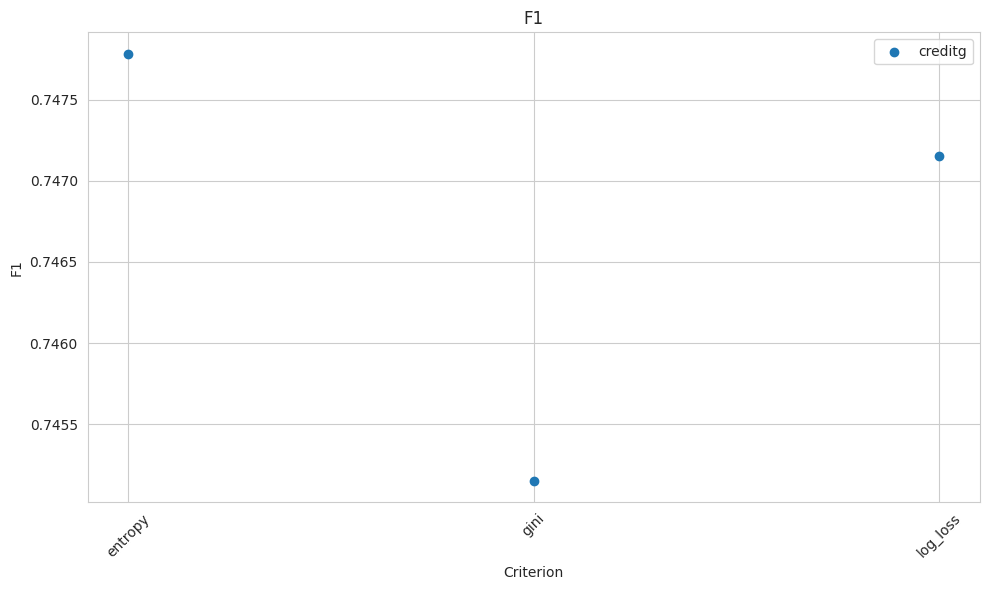

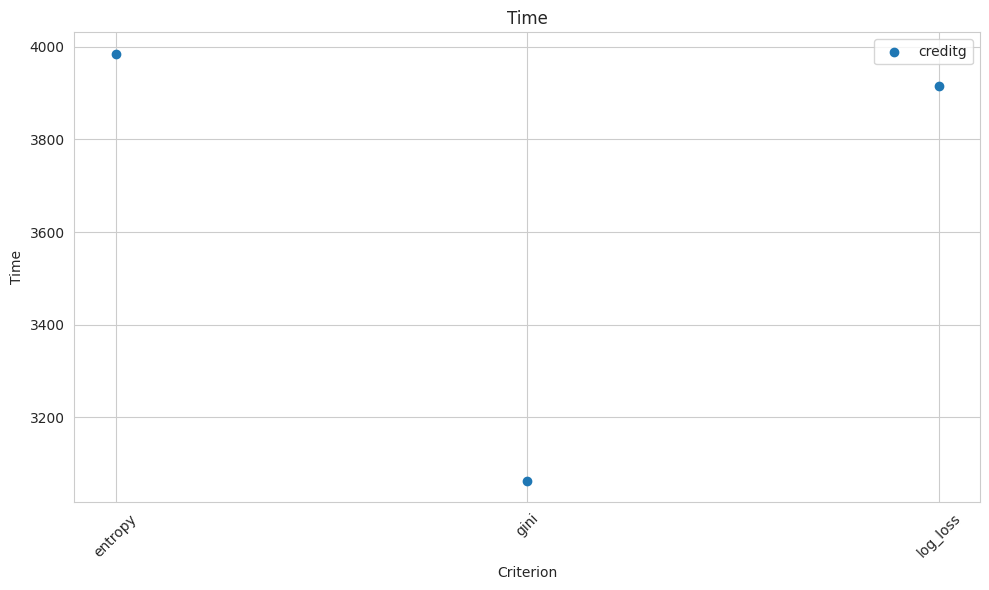

In [19]:
reload(evaluator)
hyperparameters = {
    'n_estimators': 5,
    #'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'criterion': ['gini', 'entropy', 'log_loss']}
rf_criterion = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test,
                                        hyperparameters=hyperparameters,
                                        hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)

evaluator.draw_diagram2_list({"creditg": rf_criterion, }, x_axis='criterion', y_axis=['f1', 'time'], logaritmic=False,
                             line=False)

## Bayes

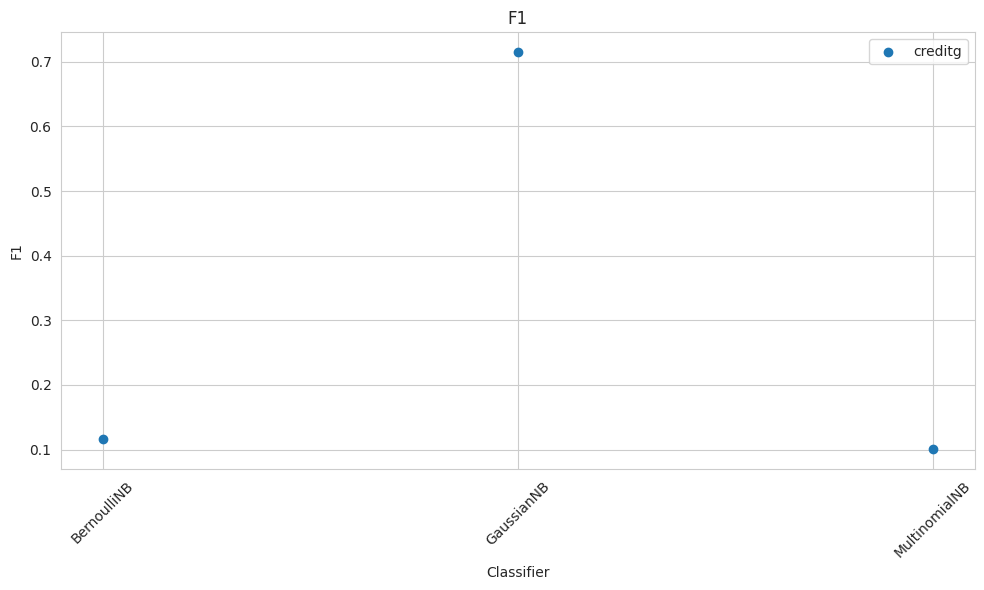

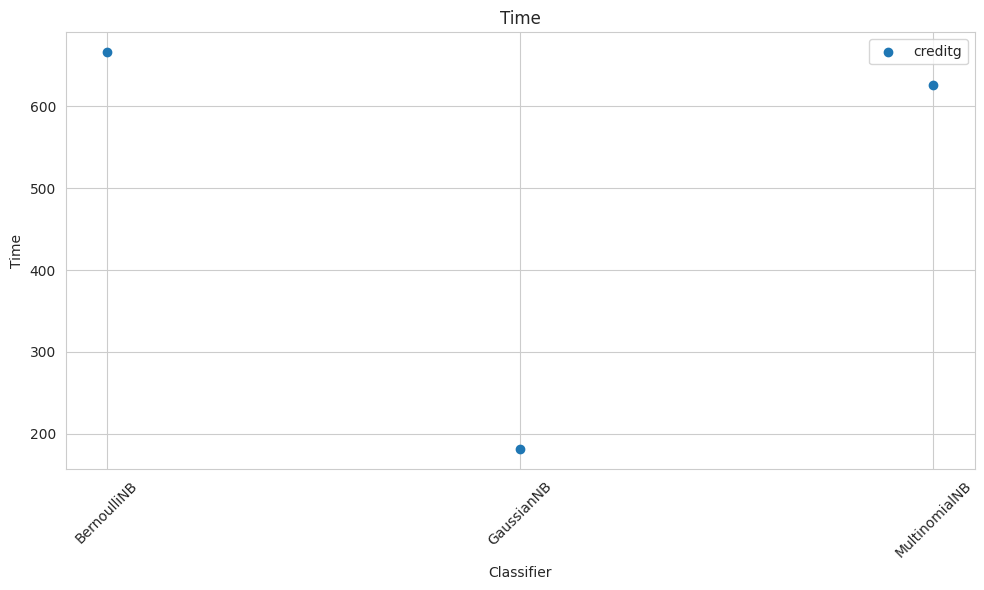

In [31]:
reload(evaluator)

classifiers = [GaussianNB, MultinomialNB, BernoulliNB]
names = ['GaussianNB', 'MultinomialNB', 'BernoulliNB']

bayes_results=evaluator.evaluate_classifier(classifiers, X_train, y_train, X_test, y_test, hyperparameters=[{},{},{},], names=names, number_of_tests=20)
evaluator.draw_diagram2_list({"creditg": bayes_results}, x_axis='classifier', y_axis=['f1', 'time'], logaritmic=False, line=False)

## evaluate scalers

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (5,), 'max_iter': 500, 'verbose': False, 'tol': 0.05}


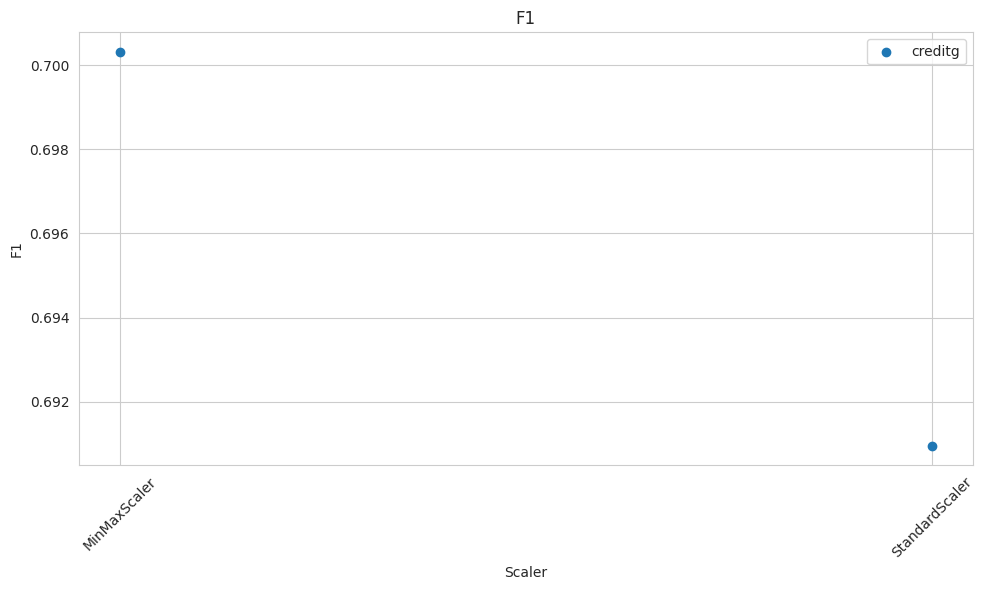

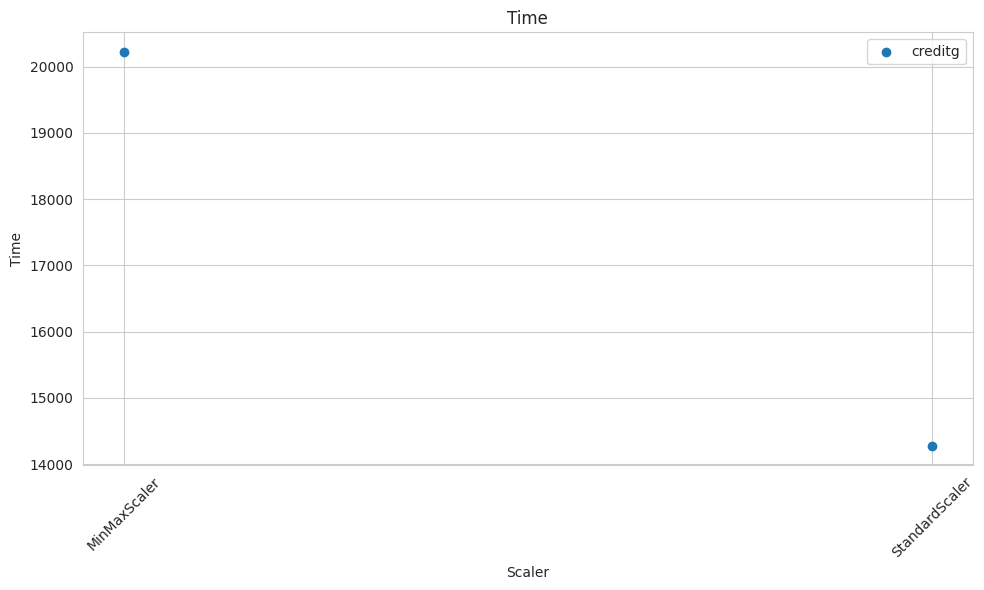

In [32]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    #'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-1,
    'hidden_layer_sizes': (5,),
    #'random_state': 7895,
    'max_iter': 500,
    'verbose': False,
    'tol': 5e-2
}

scaler_result=evaluator.evaluate_scaler(MLPClassifier, X_train=[X_train, X_train_std], y_train=[y_train, y_train], X_test=[X_test, X_test_std], y_test=[y_test, y_test], hyperparameters=hyperparameters, names=['MinMaxScaler', 'StandardScaler'], number_of_tests=3)
evaluator.draw_diagram2_list({"creditg": scaler_result}, x_axis='scaler', y_axis=['f1', 'time'], logaritmic=False, line=False)

In [34]:
combined_results_creditg = {
    # NN
    'nn_learning_rate': nn_learning_rate,
    'nn_hidden_layer': nn_hidden_layer,
    'nn_hidden_layer_deep': nn_hidden_layer_deepness,
    #'nn_max_iter': nn_max_iter,
    'act_function': act_function1,
    # RF
    'rf_n_estimators': rf_n_estimators,
    'rf_criterion': rf_criterion,
    # Bayes
    'bayes_results': bayes_results,
    'scaler_result': scaler_result
}
import pickle

with open('seattle_crime_results.pkl', 'wb') as f:
    pickle.dump(combined_results_creditg, f)

In [17]:
import pickle
with open('seattle_crime_results2.pkl', 'rb') as f:
    cr = pickle.load(f)
    cr["nn_learning_rate"] = nn_learning_rate
with open('seattle_crime_results3.pkl', 'wb') as f:
    pickle.dump(cr, f)